In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import numpy as np
from tqdm import tqdm
import argparse
import wandb
from os.path import splitext
from os import listdir
import numpy as np
import os
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
from torchvision.transforms import functional as TF
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision import models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import glob
import wandb
import random
import numpy as np
from model import *
from utils import *
from dataset import *

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
run = wandb.init()

In [3]:
dem_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/New_Data/dem'
so_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/New_Data/so'
rgb_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/New_Data/rgb'

In [4]:
pretrained_model_path = '/home/macula/SMATousi/cluster/docker-images/dem2so_more_data/pre_models/B3_rn50_moco_0099_ckpt.pth'


In [5]:
transform = RGB_RasterTransform()
    
dataset = RGB_RasterTilesDataset(dem_dir=dem_dir, so_dir=so_dir, rgb_dir=rgb_dir, transform=transform)

In [6]:
batch_size = 1
learning_rate = 0.0001
epochs = 1
number_of_workers = 0
image_size = 128
val_percent = 0.1

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=number_of_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True, drop_last=True)

    

In [7]:
model = RGB_DEM_to_SO(resnet_output_size=(8, 8), 
                            fusion_output_size=(128, 128), 
                            model_choice = "Unet_1", 
                            resnet_saved_model_path=pretrained_model_path,
                            dropout_rate=0.5)

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
from torch.optim import Adam
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [15]:
artifact = run.use_artifact('tousi-team/RGB_DEM_2_SO/model_epoch_100:v5', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model_epoch_100:v5, 144.43MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:8.7


In [9]:
model.load_state_dict(torch.load('./artifacts/model_epoch_100:v5/model_epoch_100.pth'))

<All keys matched successfully>

In [10]:
model.eval()
val_iter = iter(val_loader)

In [14]:
import time

batch = next(val_iter)
dem = batch['DEM']
so = batch['SO']
rgbs = batch['RGB']

start = time.time()
val_outputs = model(dem, rgbs)
end = time.time()

loss = criterion(val_outputs, so)

iou = mIOU(so, val_outputs)

In [15]:
print(end - start)

1.4736945629119873


In [17]:
pred = F.softmax(val_outputs, dim=1)              
pred = torch.argmax(pred, dim=1).squeeze(1)

numpy_pred = pred.numpy().squeeze()
numpy_target = so.numpy().squeeze()

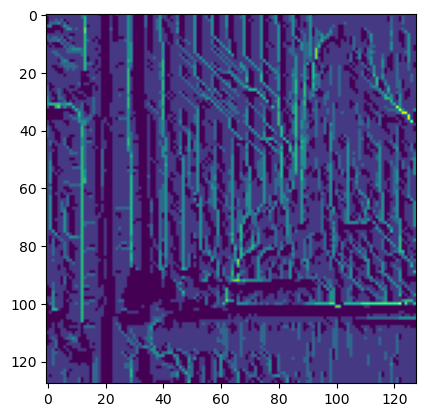

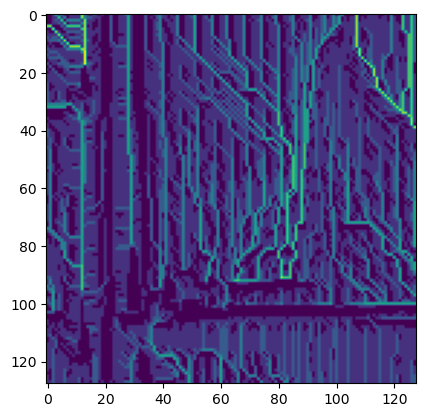

In [18]:
plt.figure()
plt.imshow(numpy_pred)
plt.figure()
plt.imshow(numpy_target)

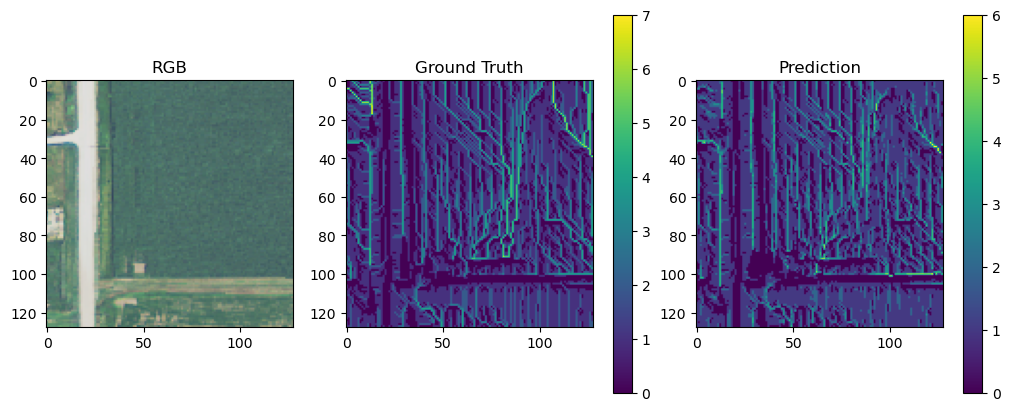

In [19]:
import matplotlib.pyplot as plt

# Assuming rgbs, numpy_target, and numpy_pred are already defined in your context

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(10, 4))

# RGB
axs[0].set_title("RGB")
rgb_display = axs[0].imshow(rgbs[0].numpy().squeeze().transpose(1, 2, 0))

# Ground Truth
axs[1].set_title("Ground Truth")
ground_truth_display = axs[1].imshow(numpy_target)
plt.colorbar(ground_truth_display, ax=axs[1], orientation='vertical')

# Prediction
axs[2].set_title("Prediction")
prediction_display = axs[2].imshow(numpy_pred)
plt.colorbar(prediction_display, ax=axs[2], orientation='vertical')

plt.show()

In [20]:
14000*12000/(128*128)

10253.90625